In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

class grid_finder:
    def __init__(self, path):
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        ind0 = img.shape[0]
        ind1 = img.shape[1]
        if (ind0 % 2 == 0):
            img = np.delete(img, 1, 0)
        if (ind1 % 2 == 0):
            img = np.delete(img, 1, 1)
        #img = (img - np.mean(img)) / np.std(img)
        self.img = img
    def plot_img(self):
        plt.figure(figsize=(30, 30))
        plt.imshow(self.img)
        plt.show()
    def calc_fft(self):
        ft = np.fft.ifftshift(self.img)
        ft = np.fft.fft2(ft)
        ft = np.fft.fftshift(ft)
        self.ft = ft
    def filter_fft(self):
        # Get rid of center peak
        filter_ft = np.copy(self.ft)
        center_inds = self.ind_remover(np.abs(filter_ft))
        for ind in center_inds:
            filter_ft[ind] = 0
        # Find four points corresponding to fundamental frequencies of grid pattern
        # We round and get the top two magnitudes, since there will be two symmetric complex conjugates for each magnitude
        filter_ft1 = np.floor(np.abs(filter_ft))
        top2 = np.sort(np.unique(filter_ft1), axis=None)[-2:]
        filter_ft[np.abs(filter_ft) < np.min(top2)] = 0
        self.ft = filter_ft
    def calc_ifft(self):
        ift = np.fft.ifftshift(self.ft)
        ift = np.fft.ifft2(ift)
        ift = np.fft.fftshift(ift)
        ift = ift.real
        self.ift = ift
    def calc_grid(self):
        self.pattern = self.shape_pattern(self.ift, self.find_peak_freqs(self.ft))
        self.grid = convolve2d(self.img, self.pattern)
    @staticmethod
    def ind_remover(array):
        temp_array = np.copy(array)
        # Find initial, central maximum
        ind = np.unravel_index(np.argmax(temp_array, axis=None), temp_array.shape)
        temp_array[ind] = 0
        inds_list = [ind]

        while True:
            # Find next position to check
            ind_new = np.unravel_index(np.argmax(temp_array, axis=None), temp_array.shape)
            # Check if position is adjacent to any existing indices
            flag = 0
            for indices in inds_list:
                dim_1_diff = abs(ind_new[0] - indices[0])
                dim_2_diff = abs(ind_new[1] - indices[1])
                if dim_1_diff == 1:
                    inds_list.append(ind_new)
                    temp_array[ind_new] = 0
                    flag = 1
                    break
                elif dim_2_diff == 1:
                    inds_list.append(ind_new)
                    temp_array[ind_new] = 0
                    flag = 1
                    break
            if flag == 0:
                break
        return inds_list
    @staticmethod
    def find_peak_freqs(filtered_ft, num_peaks=4):
        freq_rows = np.sort(np.fft.fftfreq(filtered_ft.shape[0],d=2))
        freq_cols = np.sort(np.fft.fftfreq(filtered_ft.shape[1],d=2))
        temp_array = np.copy(filtered_ft)
        inds_list = []
        for n in range(num_peaks):
            ind = np.unravel_index(np.argmax(temp_array, axis=None), temp_array.shape)
            inds_list.append(ind)
            temp_array[ind] = 0
        inds_dict = {}
        for ind in inds_list:
            inds_dict[ind] = (freq_rows[ind[0]], freq_cols[ind[1]])
        return inds_dict
    @staticmethod
    def shape_pattern(array, peak_freqs_dict):
        # Pattern is square, so we just need to find the minimum wavelenegth in one direction
        min_wavelength = np.ceil(min(abs(1/ np.array(peak_freqs_dict[list(peak_freqs_dict.keys())[0]]))))
        # Isolate region in center to copy pattern from
        pattern_start = np.array(array.shape) // 2 - np.ceil(min_wavelength /2)
        pattern_end = np.array(array.shape) // 2 + np.ceil(min_wavelength /2)
        pattern = array[int(pattern_start[0]):int(pattern_end[0]), int(pattern_start[1]):int(pattern_end[1])]
        return pattern
    @staticmethod
    def plot(array):
        plt.figure(figsize=(30, 30))
        plt.imshow(array)
        plt.show()

In [2]:
path = r"C:\Users\zc\Downloads\image004.jpg"
gf = grid_finder(path)
gf.plot_img()
gf.calc_fft()
gf.filter_fft()
gf.calc_ifft()
gf.calc_grid()
gf.plot(abs(gf.grid))

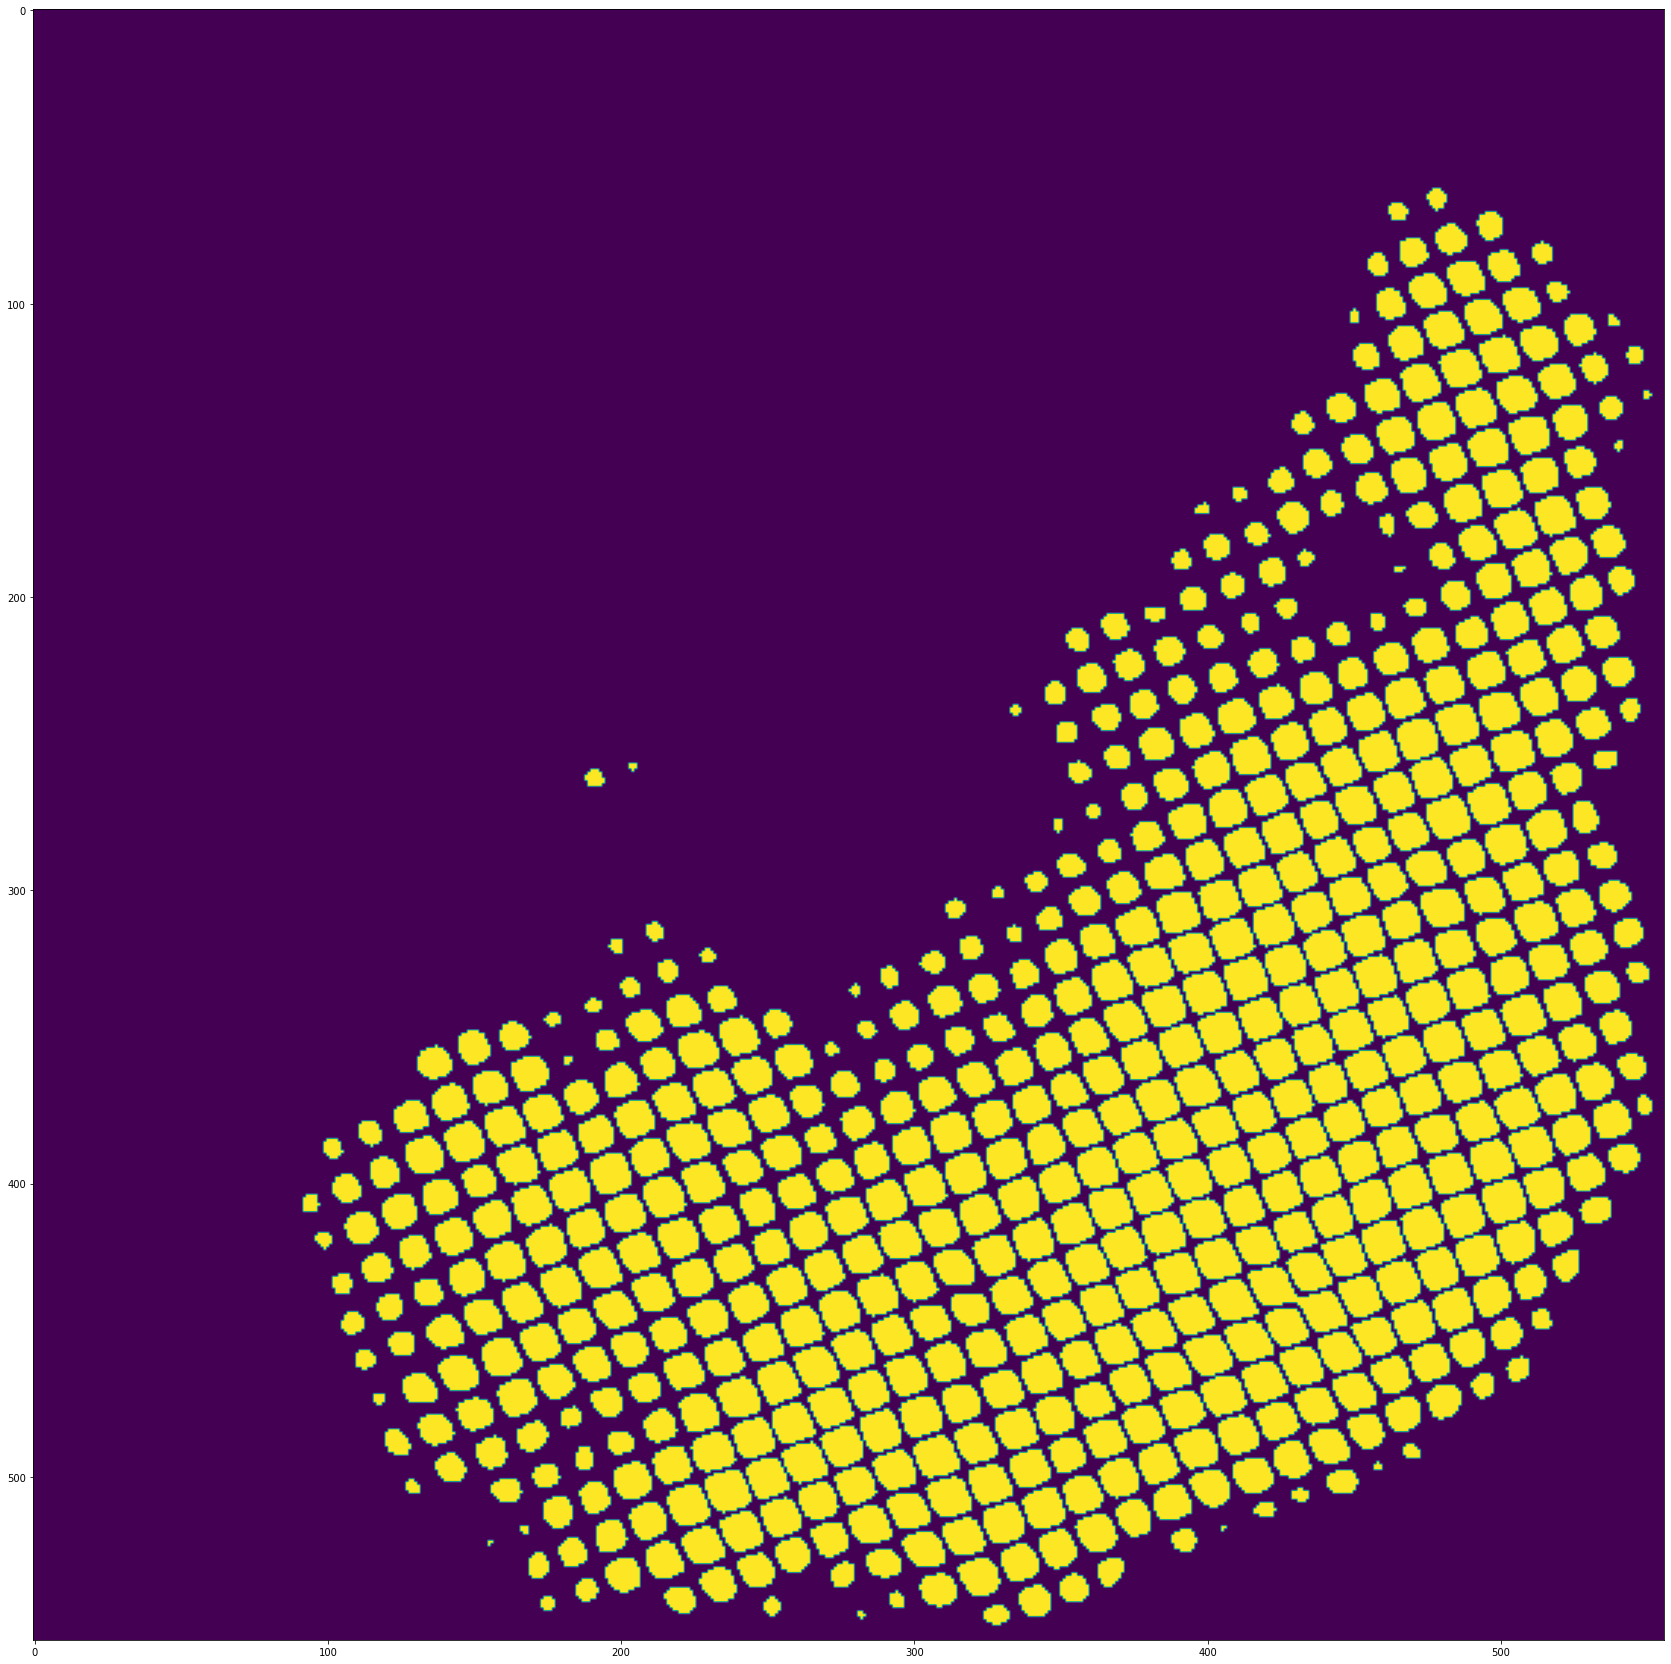

In [32]:
test_img = abs(gf.grid)
test_img[test_img <= 200000] = 0
test_img[test_img > 200000] = 1
gf.plot(test_img)

Text(0, 0.5, 'pixels')

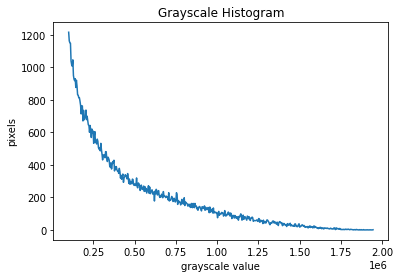

In [3]:
test_img = abs(gf.grid)
histogram, bin_edges = np.histogram(test_img[test_img>100000], bins=512)
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")

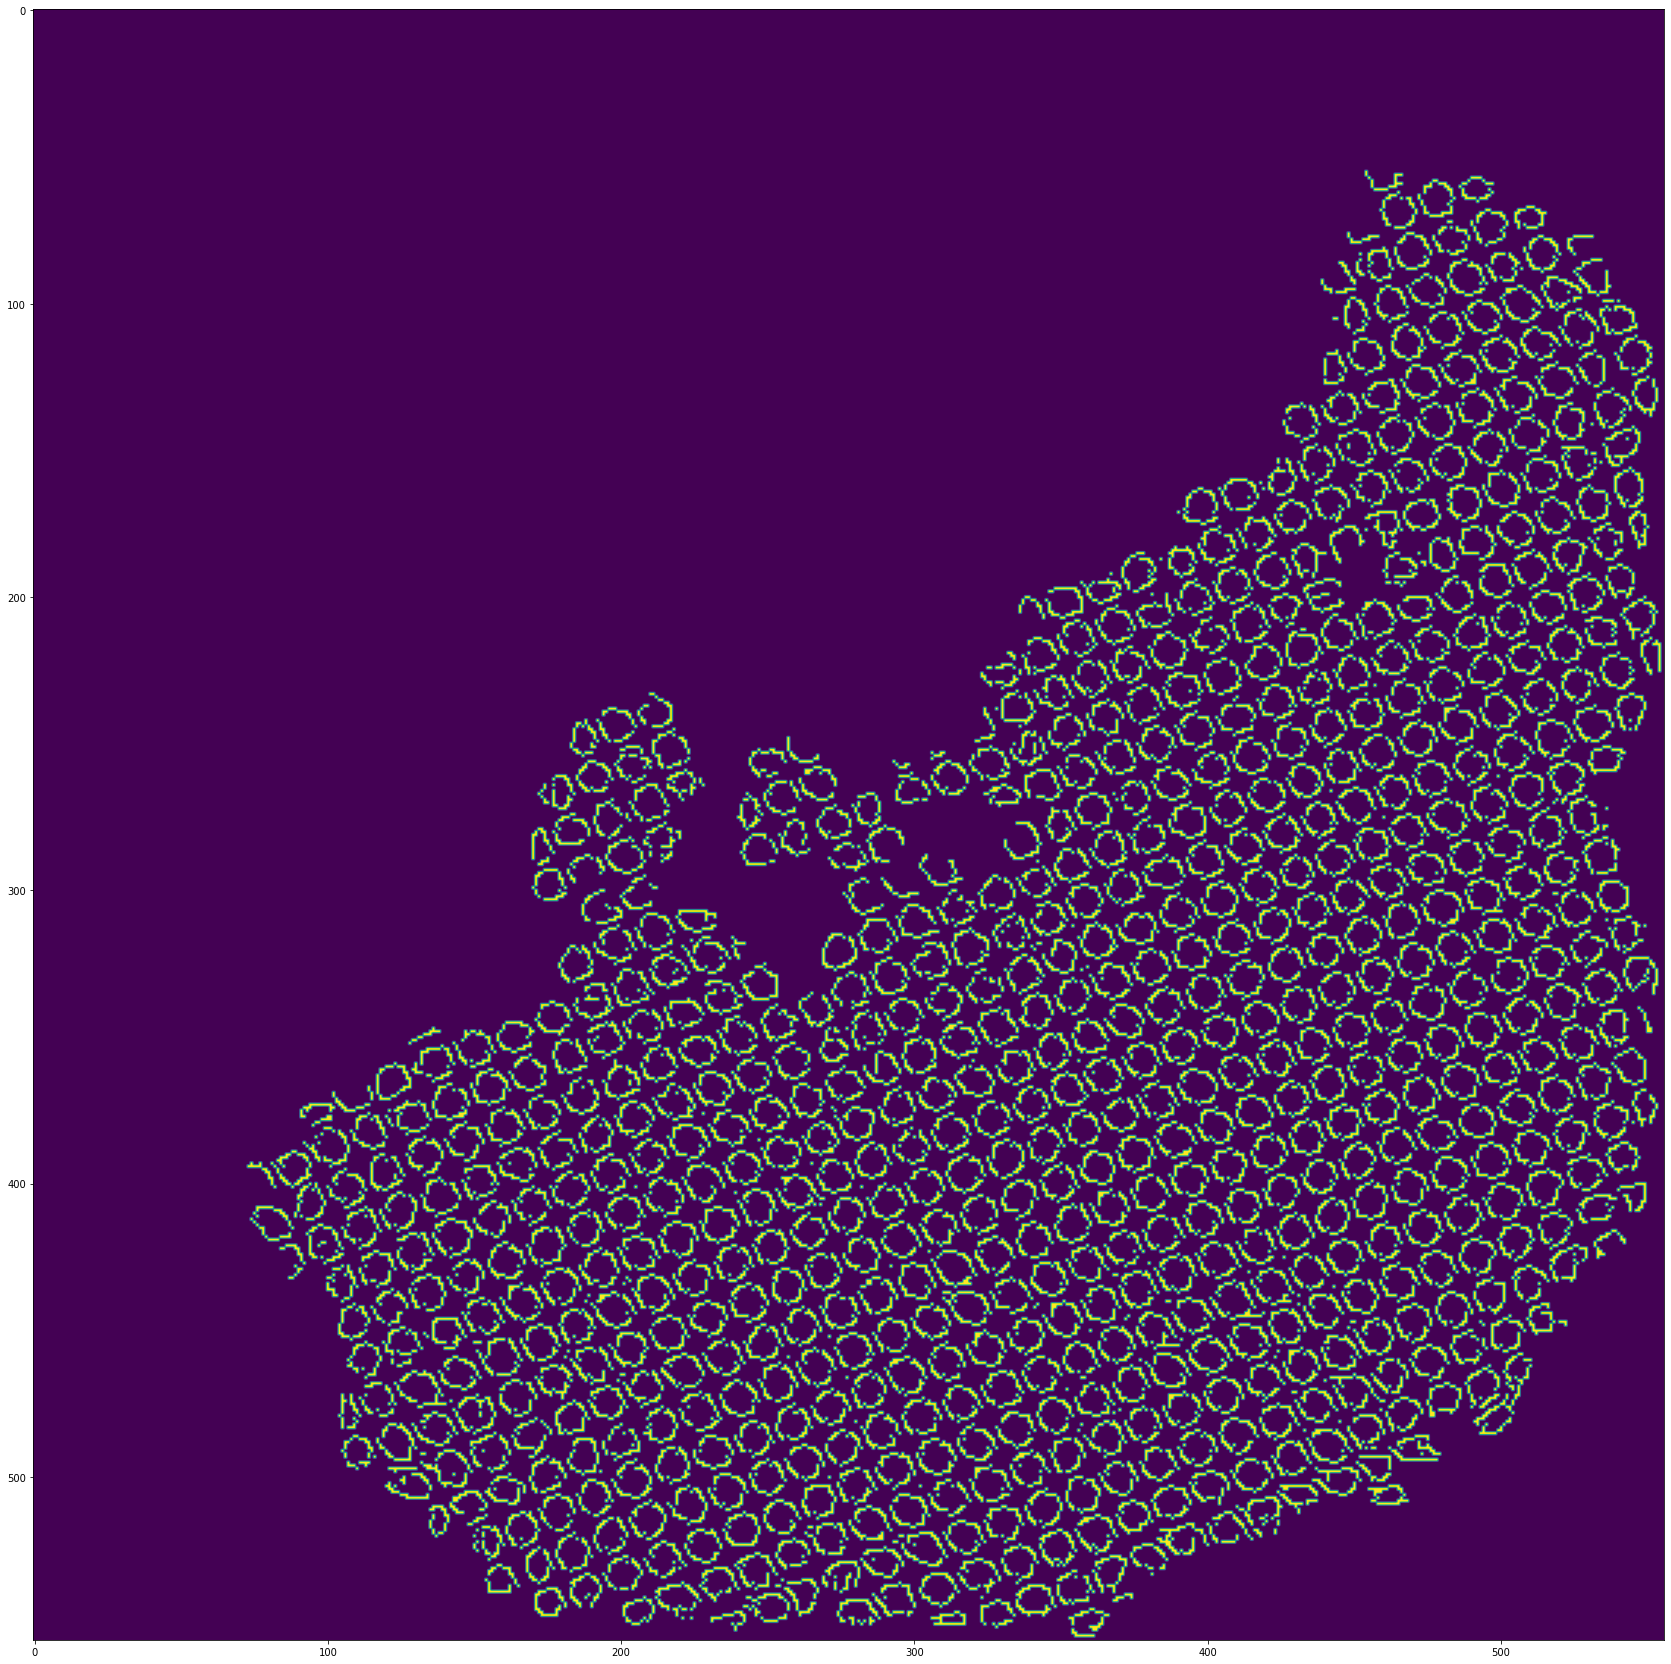

In [12]:
import random as rng

test_img2 = (test_img - np.min(test_img)) / (np.max(test_img) - np.min(test_img)) * 255
test_img2 = test_img2.astype(np.uint8)
blur = cv.GaussianBlur(test_img2,(45, 45),0)
otsu_thresh,img_ = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
edges = cv.Canny(test_img2, otsu_thresh//2, otsu_thresh)
contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

contours_poly = [None]*len(contours)
boundRect = [None]*len(contours)
drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)


for i, c in enumerate(contours):
    boundRect[i] = cv.boundingRect(contours[i])

for i in range(len(contours)):
    color = (255, 255, 255)
    cv.drawContours(drawing, contours, i, color)
    cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
      (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)

out_img = cv.drawContours(test_img2, contours, -1, (0,255,0), 3)
gf.plot(edges)
gf.plot(out_img)